# COMPARING THE BEHAVIOUR OF LATENT DIRICHLET ALLOCATION AND LATENT SEMANTIC ANALYSIS ON TOPIC MODELING FOR NEWS ARTICLES HEADLINES


## Importing Libraries

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import scipy.stats as stats
import datetime

from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
from datetime import datetime

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

## Exploratory Data Analysis

In [123]:
playstorefile = pd.read_csv('googleplaystore.csv', parse_dates = [10], infer_datetime_format = True)

In [124]:
print(playstorefile)

                                  App            Category  Rating  Reviews  \
0        DU Browser—Browse fast & fun       COMMUNICATION     4.3  1133501   
1                 Graphing Calculator               TOOLS     3.9    12388   
2        DU Browser—Browse fast & fun       COMMUNICATION     4.3  1133539   
3                    PHARMAGUIDE (DZ)  HEALTH_AND_FITNESS     4.1      131   
4                    Q*bert: Rebooted                GAME     4.3    13788   
...                               ...                 ...     ...      ...   
10836        Family Savings CU Mobile             FINANCE     4.3      323   
10837  Best Friends Dress Up & Makeup              FAMILY     3.7     7664   
10838                            EI国际              FAMILY     4.7       15   
10839    SnowMobile Parking Adventure                GAME     3.6    12257   
10840                Kim Bu Youtuber?              FAMILY     NaN       11   

       Size     Installs  Type Price Content Rating            

In [125]:
#df = playstorefile["Last_Updated"].to_frame()
#df = pd.to_datetime(df["Last_Updated"])
#df

In [126]:
#playstorefile["Last_Updated"]=playstorefile["Last_Updated"].to_frame()
#playstorefile["Last_Updated"]=pd.to_datetime(playstorefile["Last_Updated"])
playstorefile = playstorefile.set_index("Last_Updated")
playstorefile

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,datee
Last_Updated,,,,,,,,,,,,,
2016-04-01,DU Browser—Browse fast & fun,COMMUNICATION,4.3,1133501,4.7M,"10,000,000+",Free,0,Everyone,Communication,6.4.0.4,4.0 and up,20030220
2016-04-01,Graphing Calculator,TOOLS,3.9,12388,5.3M,"1,000,000+",Free,0,Everyone,Tools,1.17,2.3 and up,20030306
2016-04-01,DU Browser—Browse fast & fun,COMMUNICATION,4.3,1133539,4.7M,"10,000,000+",Free,0,Everyone,Communication,6.4.0.4,4.0 and up,20030402
2016-04-01,PHARMAGUIDE (DZ),HEALTH_AND_FITNESS,4.1,131,3.4M,"5,000+",Free,0,Everyone,Health & Fitness,1.06,1.6 and up,20030403
2017-04-01,Q*bert: Rebooted,GAME,4.3,13788,55M,"1,000,000+",Free,0,Everyone,Arcade,1.1,4.4 and up,20030312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-08,Family Savings CU Mobile,FINANCE,4.3,323,17M,"10,000+",Free,0,Everyone,Finance,4.4.47,4.0.3 and up,20030328
2015-09-09,Best Friends Dress Up & Makeup,FAMILY,3.7,7664,44M,"500,000+",Free,0,Everyone,Casual;Pretend Play,1.0.3,4.0.3 and up,20030324
2016-09-09,EI国际,FAMILY,4.7,15,5.2M,"1,000+",Free,0,Everyone,Education,1.0.4,4.0 and up,20030404


In [128]:
ps2 = playstorefile['App']
 #This is to publish the dates of the dataset in a way that can be parsed properly for further analysis like timeseries

#ps2.sort_values['Last_Updated']
ps2.sample(10) #Random sample of the dataset (10)

Last_Updated
2018-05-11                                B L Enterprises
2018-07-16                       Boomerang from Instagram
2018-06-16    Best Wallpapers Backgrounds(100,000+ 4K HD)
2018-07-27                                       Telegram
2018-07-08              Live Girls Talk - Free Video Chat
2018-05-22                           Galaxy at War Online
2016-10-07                            Gate Of Death Ep: 1
2016-09-01                                Dr. Doug's Tips
2017-08-01                                    EV Charging
2018-07-31                                      StyleSeat
Name: App, dtype: object

In [129]:
type('Last_Updated')

str

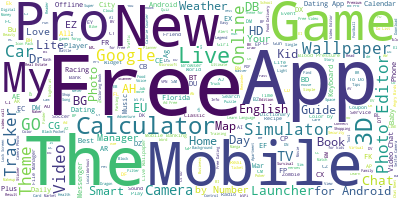

In [130]:
#Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(playstorefile['App'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Now I want to make a list of the most words used across all the apps, this will give me some insight into the core vocabulary used in the source dataset. Stop words here will be gotten rid of to prevent any kind of mistakes in accordance to conjunctions, prepositions, etc.

In [131]:
# Defining the helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    This will return a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vec_headlines = count_vectorizer.fit_transform(text_data.values)
    vec_total = np.sum(vec_headlines, axis=0)
    word_indices = np.flip(np.argsort(vec_total)[0,:], 1)
    word_values = np.flip(np.sort(vec_total)[0,:],1)
    
    word_vec = np.zeros((n_top_words, vec_headlines.shape[1]))
    for i in range(n_top_words):
        word_vec[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vec)]

    return (words, word_values[0,:n_top_words].tolist()[0])

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=ps2)

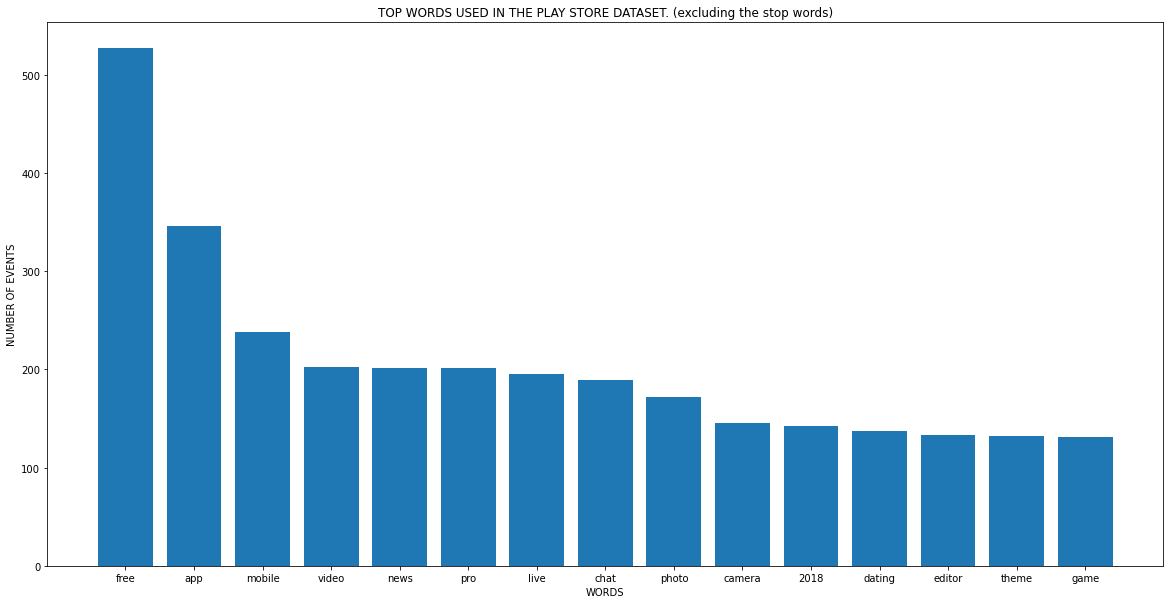

In [132]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='horizontal');
ax.set_title('TOP WORDS USED IN THE PLAY STORE DATASET. (excluding the stop words)');
ax.set_xlabel('WORDS');
ax.set_ylabel('NUMBER OF EVENTS');
plt.show()

I now want to generate a histogram to see the lengths of  App words, and use part-of-speech tagging to understand the types of words used across the corpus. This requires me to first convert all headline strings to TextBlobs and calling the 'pos_tags' method on each, yielding a list of tagged words for each App. A complete list of such word tags is available here.

In [133]:
headlines_tag = [TextBlob(ps2[i]).pos_tags for i in range(ps2.shape[0])]

In [134]:
headlines_tag_df = pd.DataFrame({'tags': headlines_tag})

word_counts = [] 
pos_counts =  {}

for headline in headlines_tag_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('THE TOTAL NUMBER OF WORDS: ', np.sum(word_counts))
print('THE MEAN OF TOTAL WORDS PER App: ', np.mean(word_counts))

THE TOTAL NUMBER OF WORDS:  41378
THE MEAN OF TOTAL WORDS PER App:  3.81680656765981


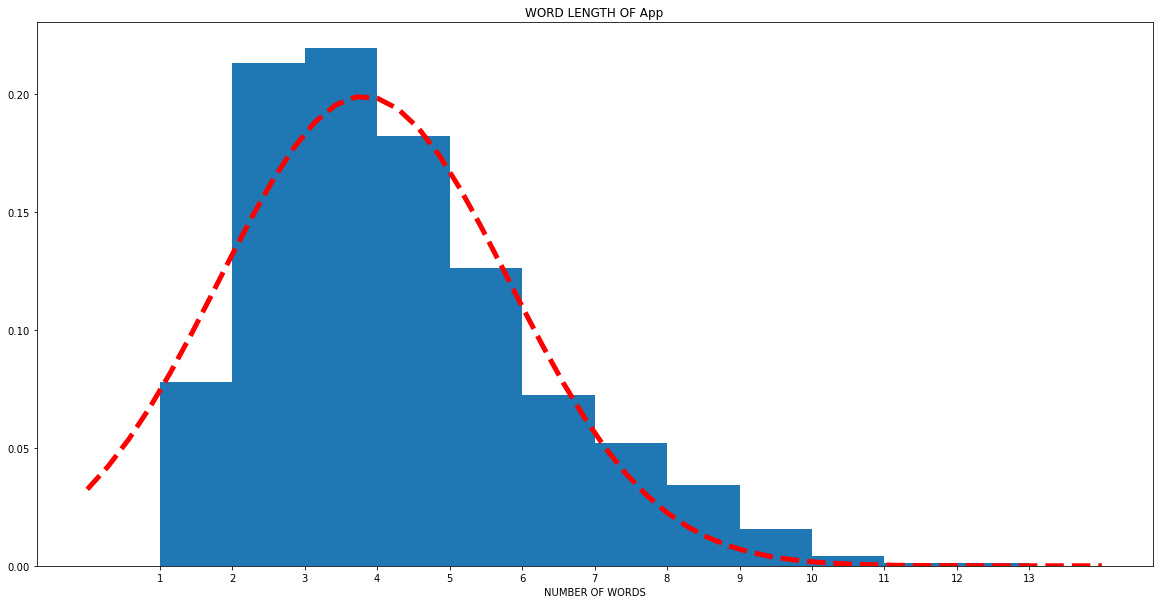

In [135]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=5);
ax.set_title('WORD LENGTH OF App');
ax.set_xticks(range(1,14));
ax.set_xlabel('NUMBER OF WORDS');
plt.show()

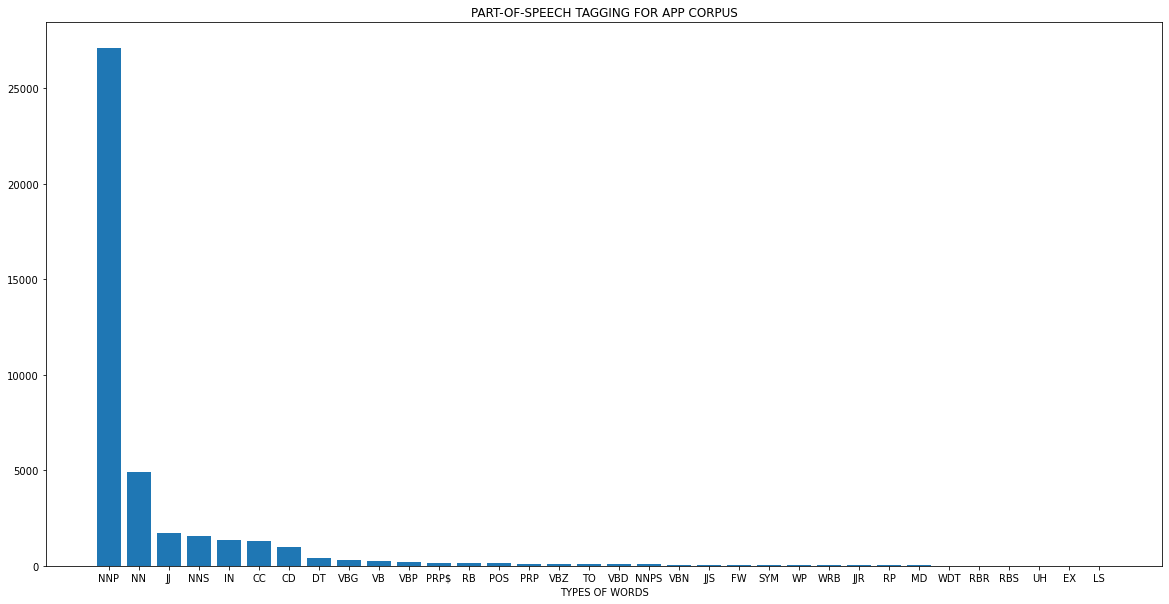

In [136]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('PART-OF-SPEECH TAGGING FOR APP CORPUS');
ax.set_xlabel('TYPES OF WORDS');

The number of Apps published per year, per month and per day can give a better insight into the sample density. I will plot this to show that.

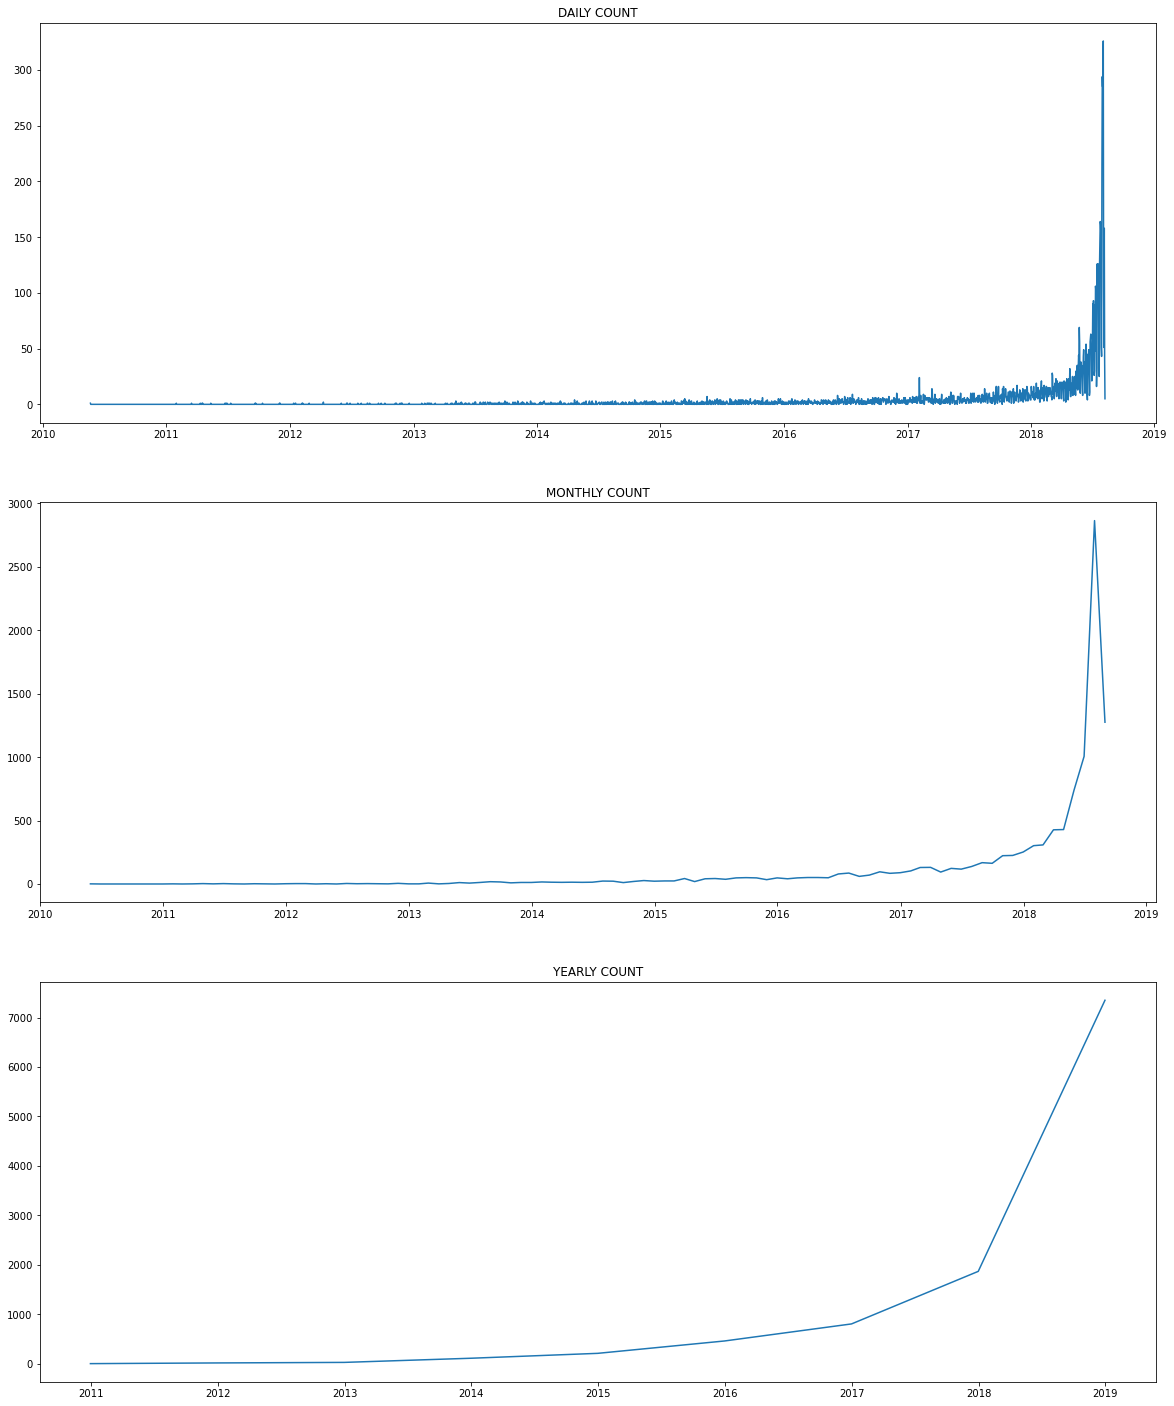

In [137]:
m_counts = ps2.resample('M').count()
y_counts = ps2.resample('A').count()
d_counts = ps2.resample('D').count()

fig, ax = plt.subplots(3, figsize=(20,25))
ax[0].plot(d_counts);
ax[0].set_title('DAILY COUNT');
ax[1].plot(m_counts);
ax[1].set_title('MONTHLY COUNT');
ax[2].plot(y_counts);
ax[2].set_title('YEARLY COUNT');
plt.show()

# TOPIC MODELLING

By applying a clustering algorithm to the headlines corpus, I can analyse the topic focus of ABC News, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine which of the two potential clustering algorithms is most appropriate – once this has been ascertained, we then scale up to a larger portion of the available data.

## Preprocessing

The only preprocessing step required in this case is feature construction, where we take the sample of text headlines and represent them in some tractable feature space. In practice, this simply means converting each string to a numerical vector. This can be done using the CountVectorizer object from SKLearn, which yields an  n×K  document-term matrix where  K  is the number of distinct words across the  n  headlines in our sample (less stop words and with a limit of max_features).

In [138]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = ps2.sample(n=10000, random_state=0).values

print('APP BEFORE VECTORIZATION: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('APP AFTER VECTORIZATION: \n{}'.format(small_document_term_matrix[123]))

APP BEFORE VECTORIZATION: BL Banking DES
APP AFTER VECTORIZATION: 
  (0, 904)	1
  (0, 709)	1
  (0, 1984)	1


Thus we have our (very high-rank and sparse) training data, small_document_term_matrix, and can now actually implement a clustering algorithm. Our choice will be either Latent Semantic Analysis or Latent Dirichlet Allocation. Both will take our document-term matrix as input and yield an  n×N  topic matrix as output, where  N  is the number of topic categories (which we supply as a parameter). For the moment, we shall take this to be 15.

In [139]:
num_topics = 15

# LATENT SEMANTIC ANALYSIS

Let's start by experimenting with LSA. This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the  r = num_topics largest singular values preserved.

In [140]:
lsa_model = TruncatedSVD(n_components=num_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

Taking the  argmax  of each headline in this topic matrix will give the predicted topics of each headline in the sample. We can then sort these into counts of each topic.

In [141]:
# Defining the helper functions
def get_keys(topic_matrix):
    '''
    This returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    This returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [142]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [143]:
# Defining the helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    This returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(num_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [144]:
top_n_words_lsa = get_top_n_words(15, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  free chat app calls ad dictionary video dating search text vpn english wifi learn ai
Topic 2:  app dating ah fk fc shopping official tracker mail cd singles fantasy mobile rich bv
Topic 3:  photo editor camera selfie collage beauty maker video candy easy dv filter makeup cam background
Topic 4:  chat video meet messenger new people live dating friends girls events random room date singles
Topic 5:  news sports world scores live videos daily watch com stats market bz breaking local results
Topic 6:  mobile banking ag bank cb ap cu ci bc ep au bt florida az cy
Topic 7:  pro calculator hd weather bn cf gps fr text fi cr wallpapers ba planner bh
Topic 8:  live learn wallpaper car english eu screen ef flights ay hotels ak dr travel aj
Topic 9:  video player maker music ek deals cv coupons ez downloader ds resume av facebook instagram
Topic 10:  game simulator games kids er real baby zombie racing doctor tracker super run dr surgery
Topic 11:  theme android launcher keyboard cm cx 

Thus we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

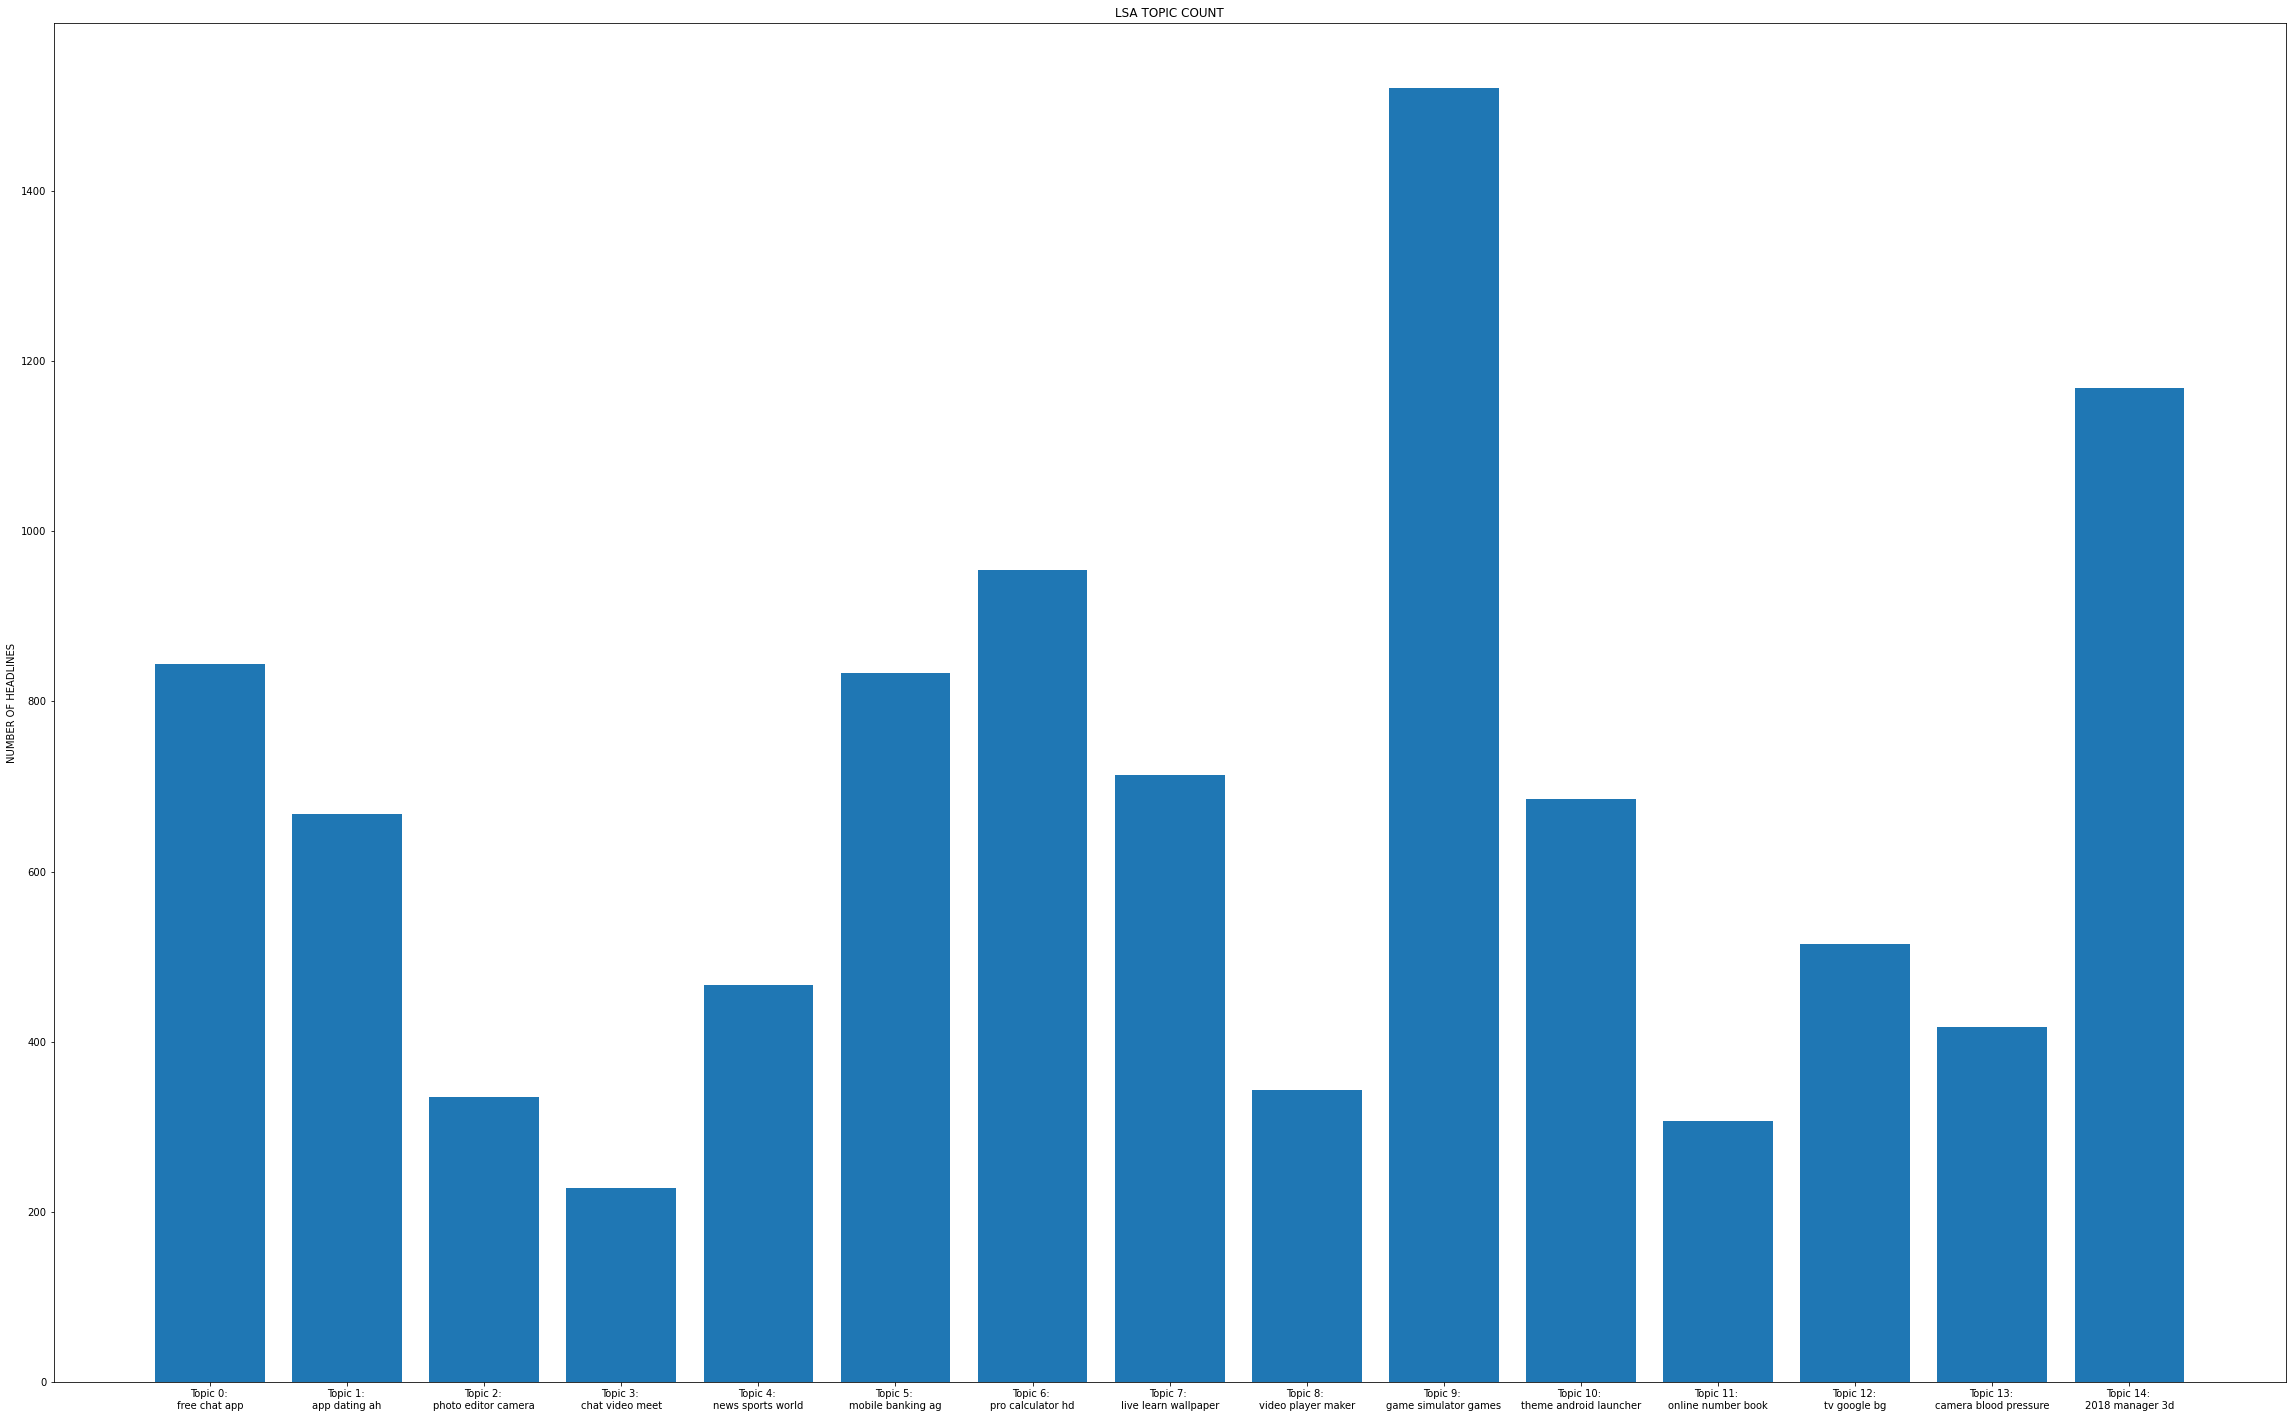

In [145]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(40,25))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('NUMBER OF HEADLINES');
ax.set_title('LSA TOPIC COUNT');
plt.show()

However, this does not provide a great point of comparison with other clustering algorithms. In order to properly contrast LSA with LDA we instead use a dimensionality-reduction technique called  t -SNE, which will also serve to better illuminate the success of the clustering process.

In [146]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.059s...
[t-SNE] Computed neighbors for 10000 samples in 2.626s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.228569
[t-SNE] KL divergence after 2000 iterations: 0.778112


Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [147]:
# Defining the helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    This returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(num_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [148]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:num_topics]

All that remains is to plot the clustered headlines. Also included are the top three words in each cluster, which are placed at the centroid for that topic.

In [149]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LSA TOPICS".format(num_topics), plot_width=900, plot_height=1000)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(num_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

Evidently, this is a bit a of a failed result. We have failed to reach any great degree of separation across the topic categories, and it is difficult to tell whether this can be attributed to the LSA decomposition or instead the  t -SNE dimensionality reduction process. Let's move forward and try another clustering technique.

# LATENT DIRICHLET ALLOCATION

We now repeat this process using LDA instead of LSA. LDA is instead a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [150]:
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

Once again, we take the  argmax  of each entry in the topic matrix to obtain the predicted topic category for each headline. These topic categories can then be characterised by their most frequent words.

In [151]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [152]:
top_n_words_lda = get_top_n_words(15, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  theme android remote dx ac sleep cm es launcher free heroes microsoft day word fn
Topic 2:  news simulator er sports bg doctor scores surgery lite live emergency hospital florida king pocket
Topic 3:  photo editor camera selfie guide cg collage ag bm beauty filter music candy fr shooter
Topic 4:  color number shopping ct coloring bt buy ci pixel cz art dm list super dc
Topic 5:  mobile dp bd bank cs pack status icon dragon ei ev id caller ball credit
Topic 6:  blood pressure radio ep ey bu bp bh vr fd world al morse code events
Topic 7:  tracker file manager cf baby calendar fe banking cu mobile au bc ai bl eo
Topic 8:  pro learn hd game gps free languages bn text real ba offline traffic ay cd
Topic 9:  free chat dating app video online calls kids manager wallpapers messenger meet scanner cx singles
Topic 10:  live tv video launcher wallpaper free english movies 3d fk hotels dictionary deals fi car
Topic 11:  google games keyboard food delivery dz dw counter calorie db poker 

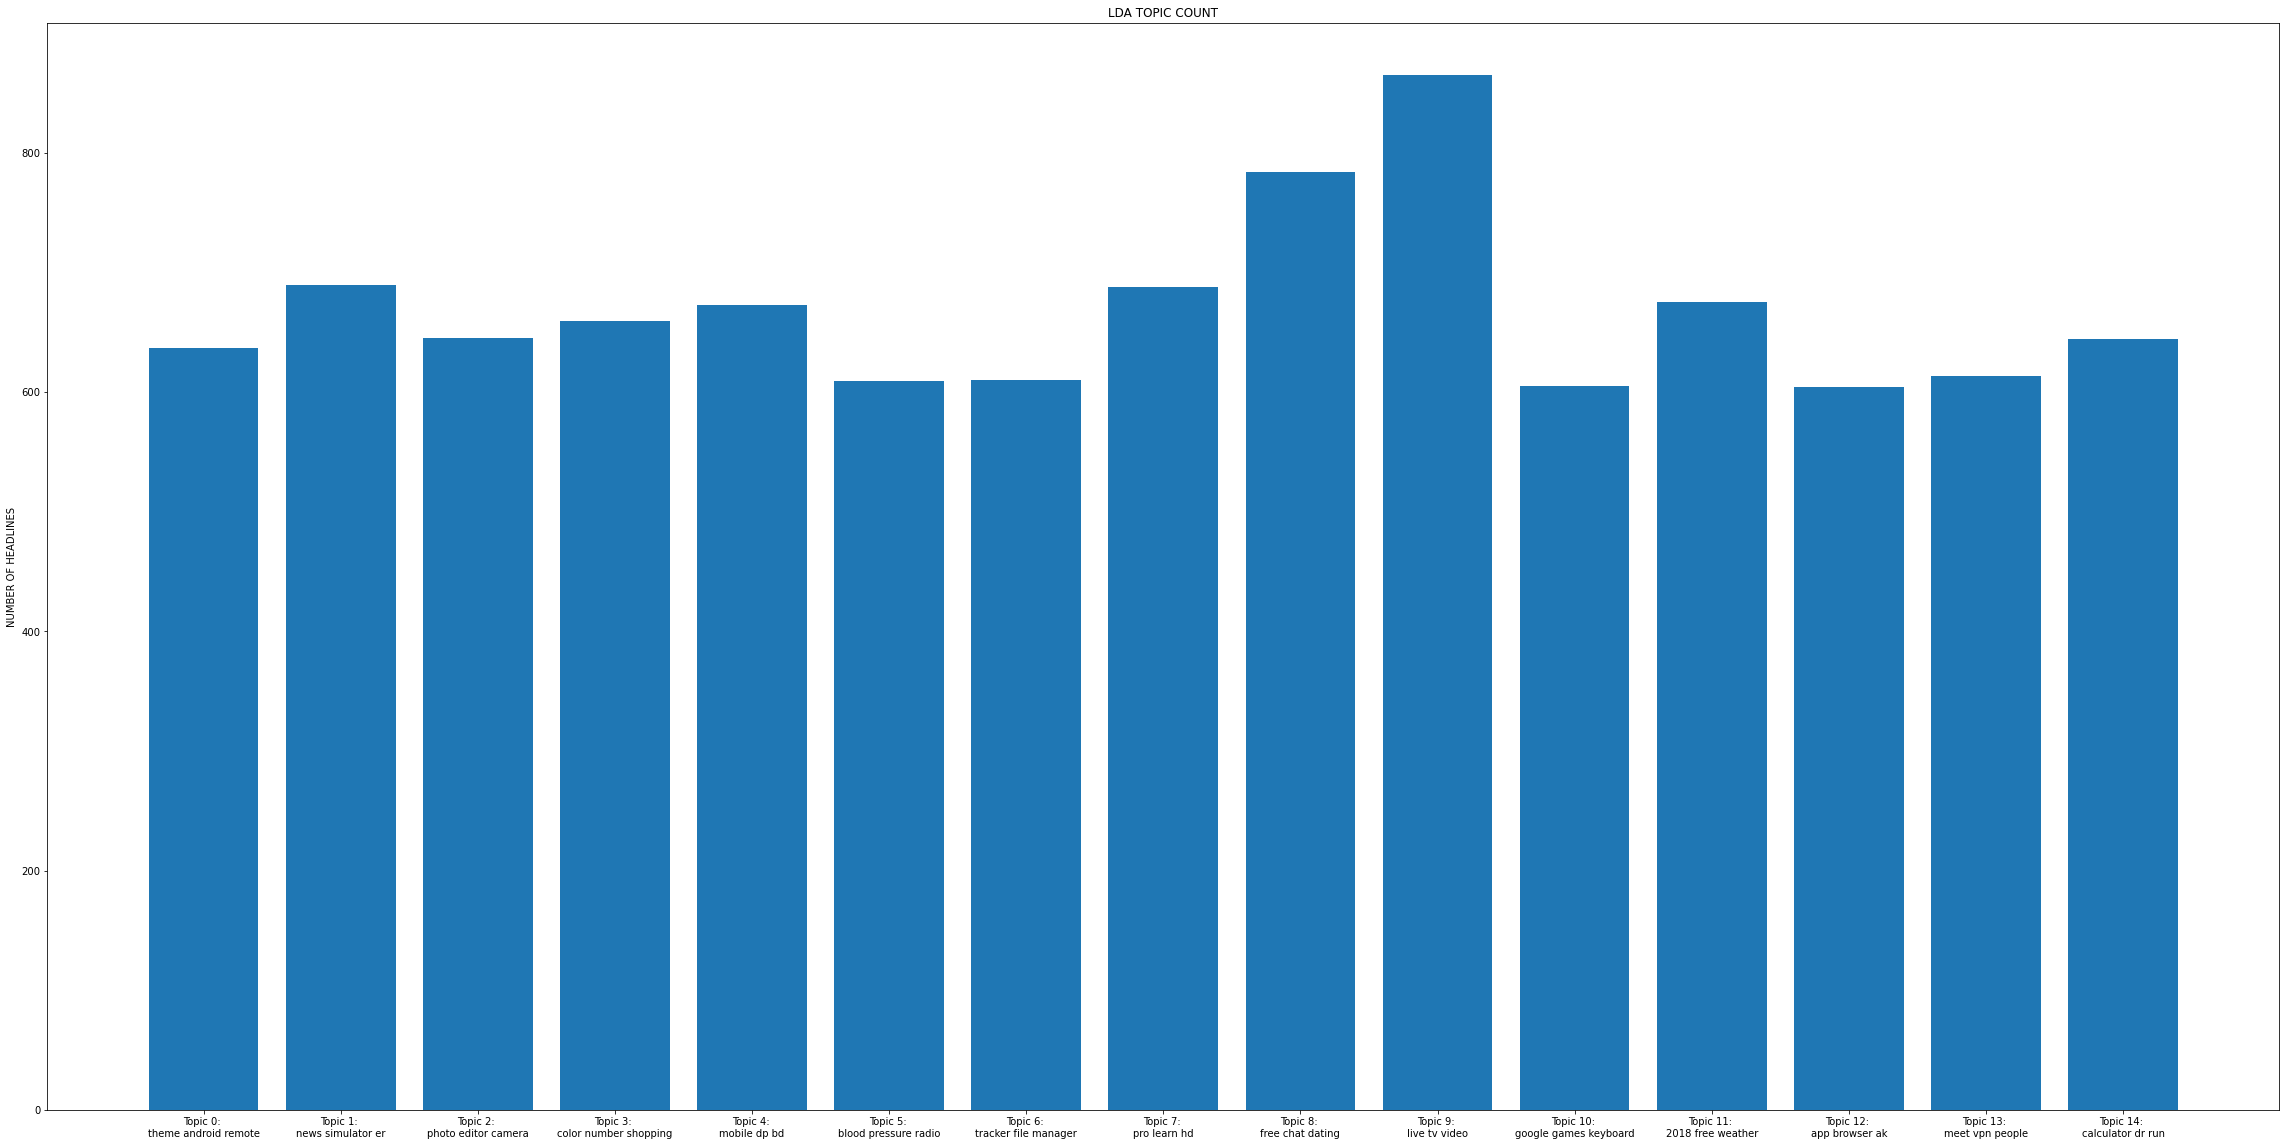

In [153]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(40,20))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA TOPIC COUNT');
ax.set_ylabel('NUMBER OF HEADLINES');

However, in order to properly compare LDA with LSA, we again take this topic matrix and project it into two dimensions with  t-SNE.

In [154]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.070s...
[t-SNE] Computed neighbors for 10000 samples in 3.517s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.312805
[t-SNE] KL divergence after 2000 iterations: 0.872048


In [155]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE CLUSTERING OF {} LDA TOPICS".format(num_topics), plot_width=900, plot_height=900)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(num_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

This is a much better result! Controlling for  t -SNE, it would seem that LDA has had much more succcess than LSA in separating out the topic categories. For this reason, LDA appears the more appropriate algorithm when we scale up the clustering process in the next section.

# SCALING UP

Now that we have found an effective clustering algorithm, we can scale it up. We still have to work with a subsample, as it is infeasible to train an LDA model one million observations, but we can significantly increase our scope to  3000  apps.

In [82]:
big_sample_size = 3000 

big_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
big_text_sample = ps2.sample(n=big_sample_size, random_state=0).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)

big_lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
big_lda_model.fit(big_document_term_matrix);
big_lda_model

LatentDirichletAllocation(learning_method='online', n_components=15)

We thus have our big topic model. The next step is to pass the entire dataset of one million headlines through this model, and sort by years. This will allow us to develop a table of topic counts per year.

In [120]:
y_data = []
for i in range(2018,2019+1):
    y_data.append(ps2['{}'.format(i)].values)
    #print(i)
    #print(y_data)
y_topic_matrices = []
for year in y_data:
    document_term_matrix = big_count_vectorizer.transform(year)
    topic_matrix = big_lda_model.transform(document_term_matrix)
    y_topic_matrices.append(topic_matrix)

y_keys = []
for topic_matrix in y_topic_matrices:
    y_keys.append(get_keys(topic_matrix))
    
y_counts = []
for keys in y_keys:
    categories, counts = keys_to_counts(keys)
    y_counts.append(counts)

y_topic_counts = pd.DataFrame(np.array(y_counts), index=range(2018,2019+1))
print(type(y_topic_counts),'topic_counts')
print(y_topic_counts)
y_topic_counts.columns = ['TOPIC {}'.format(i+1) for i in range(15)]
print(type(y_topic_counts))
print(y_topic_counts)

ValueError: Found array with 0 sample(s) (shape=(0, 3891)) while a minimum of 1 is required.

TypeError: float() argument must be a string or a number, not 'list'

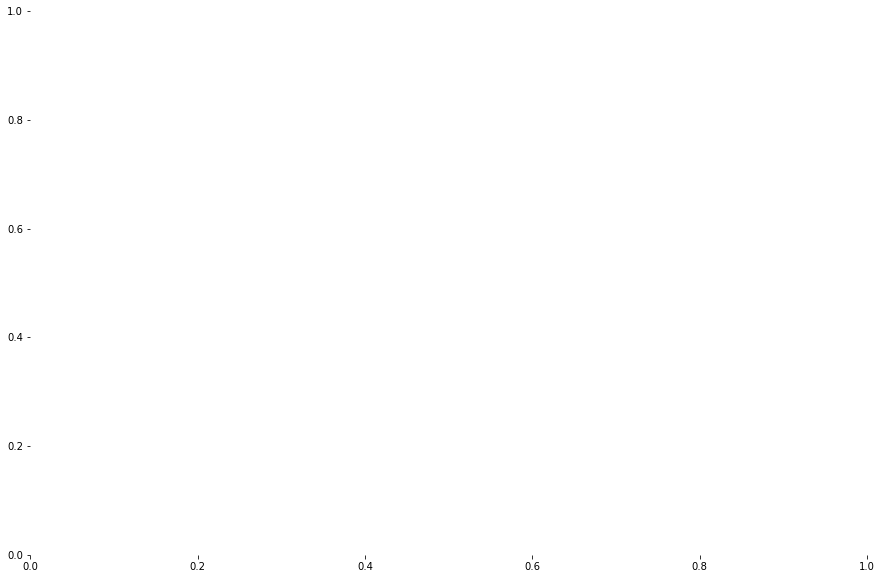

In [45]:
fig, ax = plt.subplots(figsize = (15,10))
sb.heatmap(y_topic_counts, cmap = 'Reds', ax = ax);
plt.show()

# MEANINGFUL RANDOM HEADLINES BY MARKOV CHAIN

Natural Language Generation is a very important area to be explored in our time. It forms the basis of how a bot would communicate with - not like how literates write books but like how we talk. In this Kernel, I'd like to show you a very simple but powerful Python module that does a similar exercise in (literally) a couple of lines of code.

Module: Markovify

The Py module we use here is markovify.

Descrption of Markovify:

Markovify is a simple, extensible Markov chain generator. Right now, its main use is for building Markov models of large corpora of text, and generating random sentences from that. But, in theory, it could be used for other applications.

Markov chains, named after Andrey Markov, are mathematical systems that hop from one "state" (a situation or set of values) to another. For example, if you made a Markov chain model of a baby's behavior, you might include "playing," "eating", "sleeping," and "crying" as states, which together with other behaviors could form a 'state space': a list of all possible states. In addition, on top of the state space, a Markov chain tells you the probabilitiy of hopping, or "transitioning," from one state to any other state---e.g., the chance that a baby currently playing will fall asleep in the next five minutes without crying first. Read more about how Markov Chain works in this interactive article by Victor Powell

In [186]:
import markovify #Markov Chain Generator

In [187]:
playstorefile.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver
Last_Updated,,,,,,,,,,,,
2018-01-07,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,1.0.0,4.0.3 and up
2018-01-15,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up
2018-08-01,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1.2.4,4.0.3 and up
2018-06-08,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,Varies with device,4.2 and up
2018-06-20,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,1.1,4.4 and up
2017-03-26,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,1,2.3 and up
2018-04-26,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,1.1,4.0.3 and up
2018-06-14,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,6.1.61.1,4.2 and up
2017-09-20,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,2.9.2,3.0 and up


In [188]:
import random
playstorefile.App[random.sample(range(100), 10)]

Last_Updated
2018-06-26                             Mandala Coloring Book
2018-07-31           Name Art Photo Editor - Focus n Filters
2018-07-12                    Pink Silver Bow Keyboard Theme
2017-11-07                          350 Diy Room Decor Ideas
2018-01-15                               Coloring book moana
2018-08-02                           Fuelio: Gas log & costs
2018-07-29                         Gas Prices (Germany only)
2018-06-06                   Learn To Draw Kawaii Characters
2018-01-07    Photo Editor & Candy Camera & Grid & ScrapBook
2018-04-27                     RST - Sale of cars on the PCT
Name: App, dtype: object

In [189]:
text_model = markovify.NewlineText(playstorefile.App, state_size = 2)

In [190]:
for i in range(15):
    print(text_model.make_sentence())

AVG AntiVirus 2018 for Android Wear Smart Watch
None
Universal AC Remote for Panasonic TV+BD+AVR
Turo - Better Banking
Best Park in the Kitchen
ABS Workout - Burn Belly Fat in 30 Days Fitness App for Craigslist
None
BTS J-Hope Wallpaper KPOP HD Best
K-@ Mail Pro - B&W Camera
Tubi TV - Free Unlimited VPN
ShopSavvy Barcode & QR Scanner & Barcode Scanner
DB TOS - Pocket Brainbook
None
I am Dentist - Save Small. Live Large
None


In [191]:
text_model1 = markovify.NewlineText(playstorefile.App, state_size = 3)
text_model2 = markovify.NewlineText(playstorefile.App, state_size = 4)

In [195]:
# Print three randomly-generated sentences using the built model
for i in range(10):
    print(text_model1.make_sentence())

None
None
3D Color by Number Puzzle
None
None
None
None
None
None
None


In [196]:
# Print three randomly-generated sentences using the built model
for i in range(10):
    temp = text_model2.make_sentence()
    if temp is not None: #escpaing None with this if condition as higher state markov model has generated more Nones
        print(temp)

In [197]:
text_model11 = markovify.NewlineText(playstorefile.App, state_size = 2)
text_model12 = markovify.NewlineText(playstorefile.App, state_size = 2)
model_combo = markovify.combine([ text_model11, text_model12 ], [ 1.5, 1 ])
# Print three randomly-generated sentences using the built model
for i in range(5):
    print(text_model11.make_sentence())

Pixelmania - Color by Number 2018
None
None
Live Talk - Free Chat, Dating App, Love and matching
Cardi B HD Wallpapers Volvo FH Trucks
